# Logistic Regression using MNIST

---

#### Goals

1. Making blocked code with well-defined flow-based functions
2. Doing Logistic Regression on MNIST with Mini-batch Stochastic Gradient Descent

---

#### Basic Flow of Deep Learning

![Flow Image](https://monet.postech.ac.kr/~wldh/flow.png?v=3)

---

## 1. Library Importation & Device Preparation

In [1]:
# You don't need to edit this section today.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch
import torch.nn as nn

from IPython.display import clear_output
from multiprocessing import cpu_count
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

MNIST.resources = [
  (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
    'f68b3c2dcbeaaa9fbdd348bbdeb94873'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
    'd53e105ee54ea40749a09fcbcd1e9432'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
    '9fb629c4189551a2d022fa330f9573f3'
  ), (
    'https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
    'ec29112dd5afa0611ce80d1b7f02629c'
  )
]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [2]:
# Data Loader
batch_size = 32

# Model
hidden_layer = 200

# Learning
logging_dispfig = True
maximum_epoch = 25
learning_rate = 0.1

## 3. Data Load & Preprocessing

Because MNIST dataset is already well-preprocessed imageset, we will not perform any preprocessing today.

In [3]:
# Load dataset into python variable
train_data = MNIST("./", train=True, transform=ToTensor(), target_transform=None, download=True)
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = MNIST("./", train=False, transform=ToTensor(), target_transform=None, download=True)

Train dataset length = 54000
Valid dataset length = 6000
Test dataset length = 10000

Content of Y (Label, type=<class 'int'>) = 6
Shape of X (Data, type=<class 'torch.Tensor'>) = torch.Size([1, 28, 28])


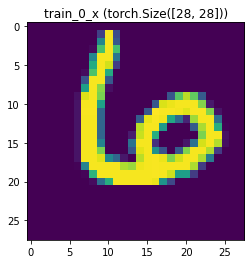

In [4]:
# Check the data
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

train_0_x, train_0_y = train_data[0]
print(f'Content of Y (Label, type={type(train_0_y)}) = {train_0_y}')
print(f'Shape of X (Data, type={type(train_0_x)}) = {train_0_x.shape}')
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title(f'train_0_x ({train_0_x.squeeze().shape})')
plt.show()

In [5]:
# Create data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

Idx: 0 / X.shape = torch.Size([32, 1, 28, 28]) / Y.shape = torch.Size([32])

Y[0:32] = tensor([9, 5, 8, 7, 8, 6, 5, 4, 6, 3, 8, 5, 2, 8, 9, 8, 4, 9, 1, 7, 6, 5, 8, 7,
        5, 5, 3, 5, 2, 3, 5, 0])


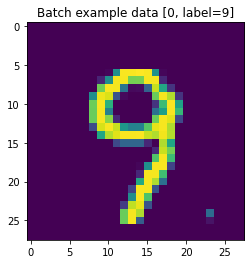

In [6]:
# Examine the data loader
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label}')

preview_index = 0
plt.figure(2)
plt.imshow(ex_data[preview_index, 0, :, :])
plt.title(f'Batch example data [{preview_index}, label={ex_label[preview_index]}]')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [7]:
# Model
def init_model():
  global net, loss_fn, optim
  net = nn.Sequential(
    nn.Linear(len(train_0_x.view([-1])), hidden_layer, bias=False),
    nn.ReLU(),
    nn.Linear(hidden_layer, 10, bias=False)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optim = SGD(net.parameters(), lr=learning_rate)
  nn.init.xavier_normal_(net[0].weight)
  nn.init.xavier_normal_(net[2].weight)

In [8]:
# Epoch
def init_epoch():
  global epoch_cnt
  epoch_cnt = 0

  
def epoch(data_loader):
  # One epoch : gets data_loader as input and returns loss / accuracy, and
  #             last prediction value / its label(truth) value for future use
  global epoch_cnt
  iter_loss, iter_acc = [], []
  
  last_out, last_label = None, None
  last_grad_performed = False
  
  # Mini-batch iterations
  for _data, _label in data_loader:
    data, label = _data.view([len(_data), -1]).to(device), _label.to(device)
    
    # 1. Feed-forward
    onehot_out = net(data)
    
    # 2. Calculate accuracy
    _, out = torch.max(onehot_out, 1)
    acc_partial = (out == label).float().sum()
    acc_partial = acc_partial / len(label)
    iter_acc.append(acc_partial.item())
    
    # 3. Calculate loss
    loss = loss_fn(onehot_out, label)
    iter_loss.append(loss.item())
    
    # 4. Backward propagation if not in `torch.no_grad()`
    if onehot_out.requires_grad:
      optim.zero_grad()
      loss.backward()
      optim.step()
      last_grad_performed = True
      
    # 5. Save current iteration data for future use
    last_out = out.cpu().detach()
    last_label = _label
      
  # Up epoch count if backward propagation is done
  if last_grad_performed:
    epoch_cnt += 1
    
  return np.average(iter_loss), np.average(iter_acc), last_out, last_label


def epoch_not_finished():
  # For now, let's repeat training fixed times, e.g. 25 times.
  # We will learn how to determine training stop or continue later.
  return epoch_cnt < maximum_epoch

In [9]:
# Logging
def init_log():
  global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
  iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
  time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
  # Push time, training loss, training accuracy, and epoch count into lists
  time_log.append(_time)
  tloss_log.append(_tloss)
  tacc_log.append(_tacc)
  iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
  # Push validation loss and validation accuracy into each list
  vloss_log.append(_vloss)
  vacc_log.append(_vacc)
  

def last(log_list):
  # Get the last member of list. If empty, return -1.
  if len(log_list) > 0: return log_list[len(log_list) - 1]
  else: return -1
  
  
def print_log():
  # Generate log string and put it into log stack
  log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
  log_stack.append(log_str)
  
  # Draw figure if want
  if logging_dispfig:
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
    hist_fig.patch.set_facecolor('white')
    
    # Draw loss lines
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Draw accuracy lines
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # Append annotations
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title(f'Learning history until epoch {last(iter_log)}')
    plt.draw()
    
  # Print log
  clear_output(wait=True)
  if logging_dispfig: plt.show()
  for idx in reversed(range(len(log_stack))):
    print(log_stack[idx])

## 5. Training Iteration

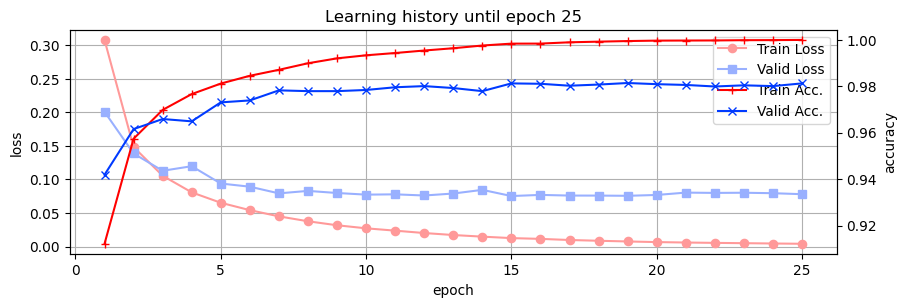

Iter:   25 >> T_loss 0.00416    T_acc 0.99987   V_loss 0.07802    V_acc 0.98117   🕒 7.130s
Iter:   24 >> T_loss 0.00458    T_acc 0.99980   V_loss 0.07948    V_acc 0.98000   🕒 6.880s
Iter:   23 >> T_loss 0.00505    T_acc 0.99976   V_loss 0.08017    V_acc 0.98033   🕒 6.718s
Iter:   22 >> T_loss 0.00550    T_acc 0.99965   V_loss 0.07992    V_acc 0.97983   🕒 6.878s
Iter:   21 >> T_loss 0.00604    T_acc 0.99961   V_loss 0.08037    V_acc 0.98050   🕒 6.924s
Iter:   20 >> T_loss 0.00669    T_acc 0.99957   V_loss 0.07687    V_acc 0.98083   🕒 6.744s
Iter:   19 >> T_loss 0.00761    T_acc 0.99939   V_loss 0.07561    V_acc 0.98133   🕒 6.759s
Iter:   18 >> T_loss 0.00865    T_acc 0.99913   V_loss 0.07594    V_acc 0.98067   🕒 6.691s
Iter:   17 >> T_loss 0.00979    T_acc 0.99885   V_loss 0.07596    V_acc 0.98017   🕒 6.745s
Iter:   16 >> T_loss 0.01146    T_acc 0.99830   V_loss 0.07695    V_acc 0.98100   🕒 6.725s
Iter:   15 >> T_loss 0.01262    T_acc 0.99828   V_loss 0.07526    V_acc 0.98117   🕒 6.740s

In [10]:
# Training Initialization
init_model()
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
  start_time = time.time()
  tloss, tacc, _, _ = epoch(train_loader)
  end_time = time.time()
  time_taken = end_time - start_time
  record_train_log(tloss, tacc, time_taken)
  with torch.no_grad():
    vloss, vacc, _, _ = epoch(valid_loader)
    record_valid_log(vloss, vacc)
  print_log()
  
print('\n Training completed!')

## 6. Result Analysis

In this section, we will calculate accuracy and confusion matrix for test dataset.

In [11]:
# Accuracy for test dataset
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader)
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

Test accuracy = 0.9800999760627747
Test loss = 0.06513695418834686


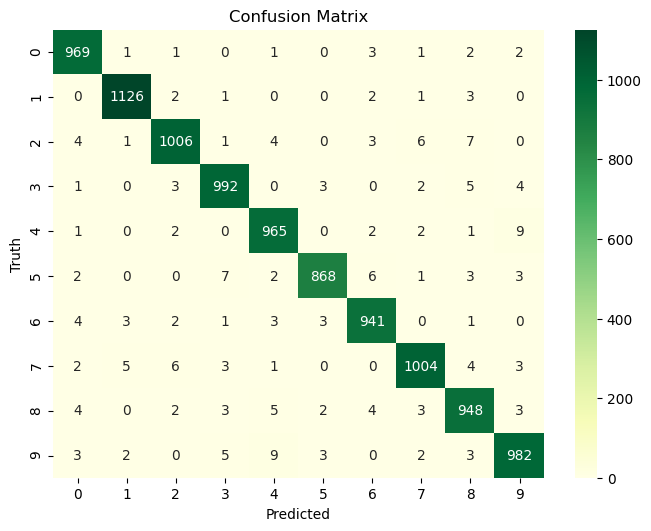

In [12]:
# Confusion matrix
our_cmatrix = confusion_matrix(test_label, test_out)
plt.figure(figsize=(8, 6), dpi=99)
sns.heatmap(our_cmatrix, annot=True, fmt='g', cmap='YlGn').set(xlabel='Predicted', ylabel='Truth')
plt.title('Confusion Matrix')
plt.show()

## 7. Saving Model

Are you satisfied with your model? Then save it!

In [13]:
torch.save(net, './model.pkl')

If you want to load your model, enter below.

In [14]:
net = torch.load('./model.pkl')